# Regresión lineal: predecir los gastos médicos de pacientes
---

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos. 


## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [6]:
!pip install regressors

In [7]:
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
import kaggle 
kaggle.api.authenticate()
kaggle.api.dataset_download_files('mirichoi0218/insurance', path='./', unzip=True)
kaggle.api.dataset_download_files('mirichoi0218/insurance', path='.')

Dataset URL: https://www.kaggle.com/datasets/mirichoi0218/insurance
Dataset URL: https://www.kaggle.com/datasets/mirichoi0218/insurance


## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [8]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

(1338, 7)


<Axes: >

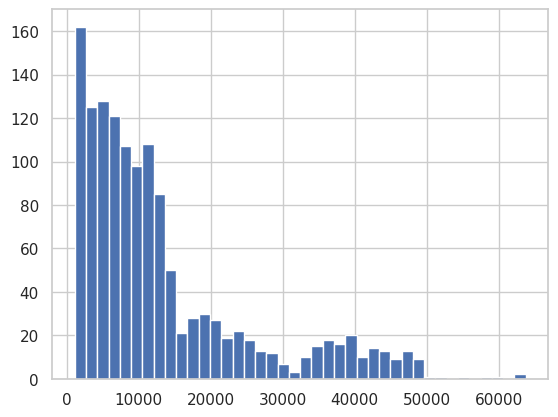

In [9]:
print(df.shape)
df.charges.hist(bins = 40)

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [10]:
df[df.charges>50000]
df = df[df.charges<50000]

En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio. 

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

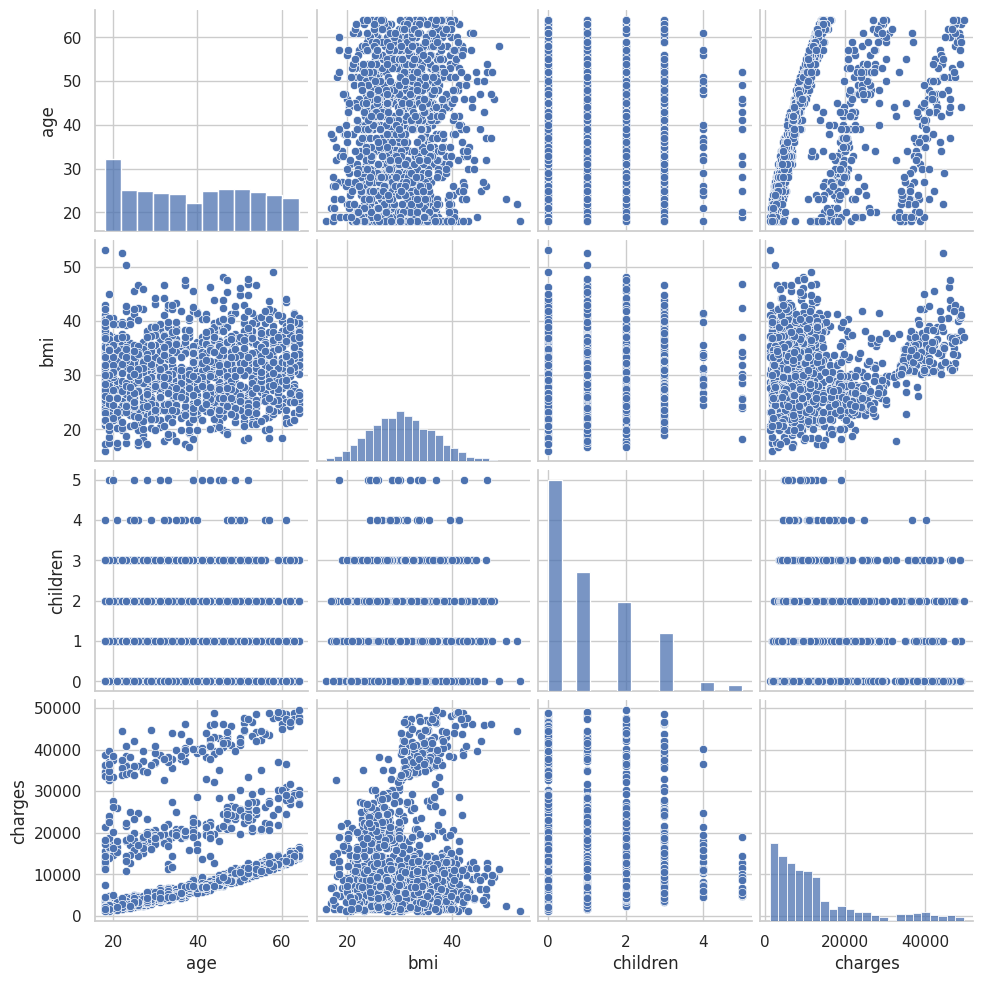

In [11]:
sns.pairplot(df)




## Viendo correlaciones
Ahora entendamos nuestros datos, viendo cómo se distribuyen y correlacionan. 

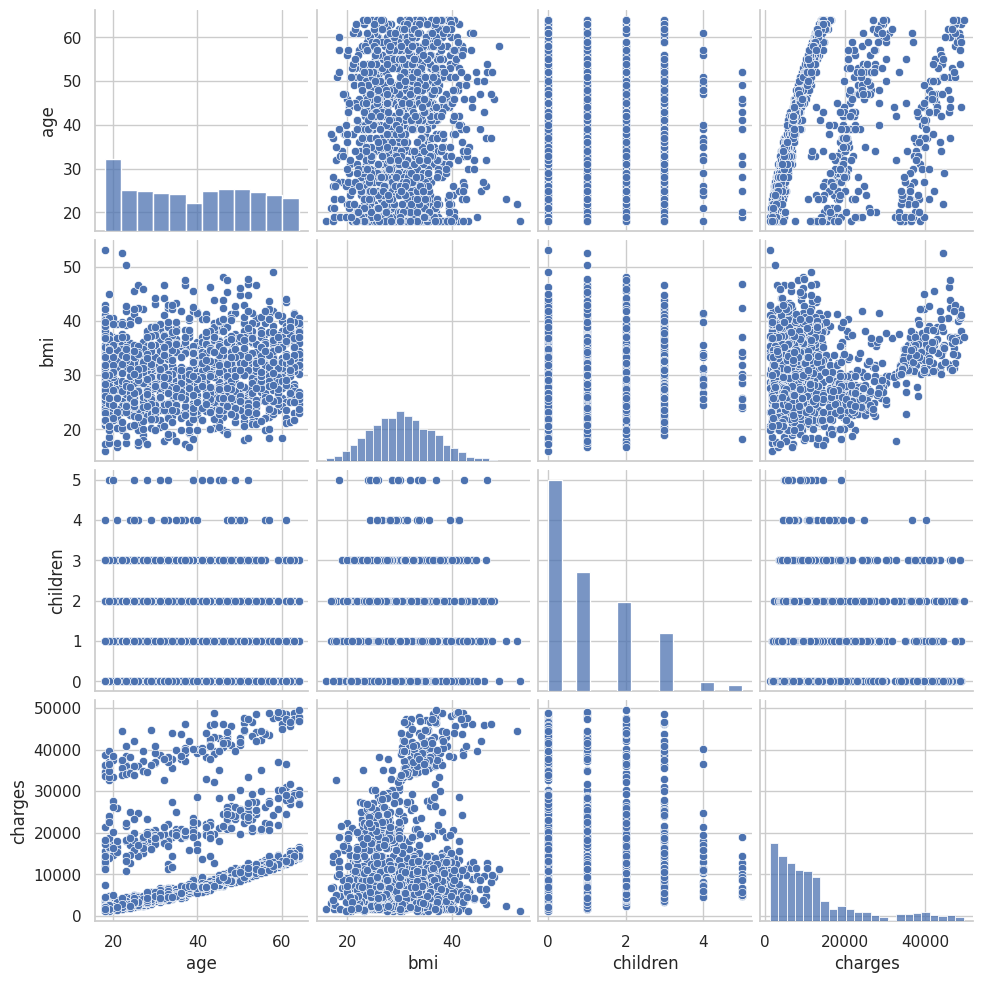

In [12]:
import matplotlib.pyplot as plt
sns.pairplot(df, height=2.5)
plt.show()


Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

<Axes: >

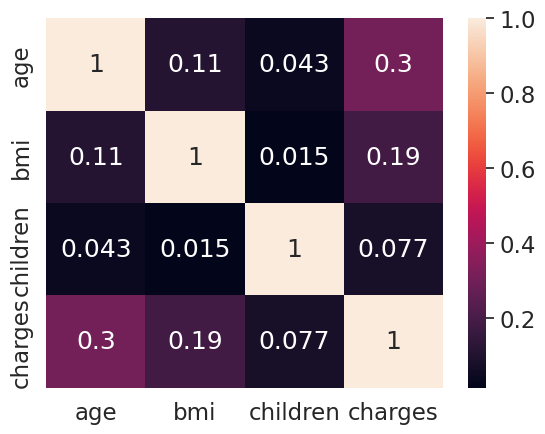

In [13]:
import numpy as np
numeric_cols = ['age', 'bmi', 'children', 'charges']
cm = np.corrcoef(df[numeric_cols].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True, yticklabels=numeric_cols,xticklabels=numeric_cols)

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función get_dummies de pandas. 

Ahora la verás en acción

In [14]:
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [15]:
cols_categoricas = [colname for colname in df.columns if df[colname].nunique() < 10 and df[colname].dtype == 'object']

In [16]:
df.corr().style.background_gradient(cmap="coolwarm", axis=None)

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.108331,0.043197,0.304561,-0.022425,-0.028377,-0.000367,-0.013238,0.009735
bmi,0.108331,1.000000,0.014860,0.187061,0.048915,-0.006159,-0.136642,0.270376,-0.005691
children,0.043197,0.014860,1.000000,0.076993,0.016042,0.011084,0.022816,-0.021127,0.022816
charges,0.304561,0.187061,0.076993,1.000000,0.057519,0.785617,-0.043506,0.074787,-0.045242
sex_male,-0.022425,0.048915,0.016042,0.057519,1.000000,0.075786,-0.010787,0.017669,-0.007282
smoker_yes,-0.028377,-0.006159,0.011084,0.785617,0.075786,1.000000,-0.038487,0.069074,-0.038487
region_northwest,-0.000367,-0.136642,0.022816,-0.043506,-0.010787,-0.038487,1.000000,-0.345990,-0.320437
region_southeast,-0.013238,0.270376,-0.021127,0.074787,0.017669,0.069074,-0.345990,1.000000,-0.345990
region_southwest,0.009735,-0.005691,0.022816,-0.045242,-0.007282,-0.038487,-0.320437,-0.345990,1.000000


## Creando modelos 
Primero se usará un modelo con todas las variables.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [18]:
X_cols = list(set(df.columns)-set(['charges']))
y_col = ['charges']

X = df[X_cols].values
y = df[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)


In [19]:
y_pred.shape

(333, 1)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [21]:
%%capture
%pip install statsmodels

# Add summary of coefficients (estimates, Std. Error, t value, p value) and residuals (min, 1q, median, 3q, max)
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_sm)
results = model.fit()

print(results.summary())

In [22]:
from sklearn.metrics import mean_squared_error, r2_score 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('r2', r2.round(4))
print('mse', mse.round(4))

AttributeError: 'float' object has no attribute 'round'

In [23]:
from regressors import stats
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

AttributeError: 'OLS' object has no attribute 'intercept_'

El siguiente código muestra un resumen general de los resultados.

In [24]:
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========


AttributeError: 'OLS' object has no attribute 'intercept_'

Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

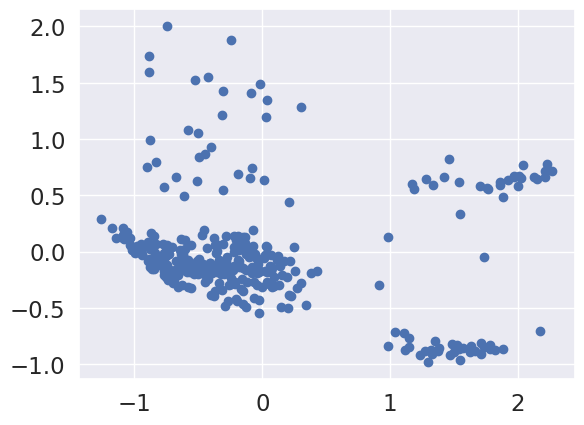

In [25]:

residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()

## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [26]:
df_second = df.copy()
df_second['age2'] = df_second.age**2
df_second['sobrepeso'] = (df_second.bmi >= 30).astype(int)
df_second['sobrepeso*fumador'] = df_second.sobrepeso * df_second.smoker_yes

Analizando el segundo modelo

In [27]:
X_cols = ['sobrepeso*fumador', 'smoker_yes', 'age2', 'children']
y_col = ['charges']

X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression(fit_intercept=False)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [28]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

AttributeError: 'float' object has no attribute 'round'

In [29]:
model.coef_ = model.coef_.reshape(-1)

In [30]:
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min     1Q  Median    3Q    Max
-2.0347 0.0633  0.1022 0.132 0.3999


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000000    0.020615   0.0000  1.000000
sobrepeso*fumador  0.495422    0.028766  17.2222  0.000000
smoker_yes         0.465057    0.030484  15.2556  0.000000
age2               0.313637    0.020556  15.2579  0.000000
children           0.074504    0.021681   3.4363  0.000665
---
R-squared:  0.84113,    Adjusted R-squared:  0.83919
F-statistic: 434.15 on 4 features


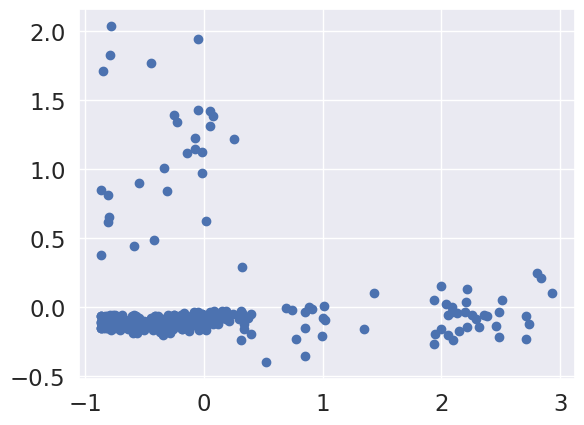

In [31]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()